In [2]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))

In [3]:
from utils.data_utils import load_recording
from utils.data_utils import plot_first_n, plot_spec
import torch
from tqdm import tqdm
import yaml
from models.bendr import EncoderConv, ContextNetwork

with open('configs/od_config_bendr.yaml', 'r') as file:
        cfg = yaml.safe_load(file)


encoder_sd = torch.load('/workspace/checkpoints_70ep/encoder_2024-12-23T19:57:53.101820.pt', map_location=torch.device('cpu') )
context_network_sd = torch.load('/workspace/checkpoints_70ep/context_network_2024-12-23T19:57:53.101820.pt', map_location=torch.device('cpu') )


encoder = EncoderConv(**cfg['encoder'])
context_network = ContextNetwork(**cfg['context_network'])

encoder.load_state_dict(encoder_sd)
context_network.load_state_dict(context_network_sd)
encoder.eval()
context_network.eval()

/tmp/ipykernel_2813/2474928465.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_sd = torch.load('/workspace/checkpoints_70ep/encoder_2024-12-23T19:57:53.101820.p

ContextNetwork(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-19): 20 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (target_proj): Linear(in_features=512, out_features=512, bias=True)
  (positional_emb): SinusoidalPositionalEncoding(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=False)
  )
)

In [4]:
from dataset.labeled_dataset import EEGLabeledDataset
from torch.utils.data import DataLoader

dataset = EEGLabeledDataset(
    data_path='/root/full_clean/h5',
    cache_processed_path='/root/full_clean/cache',
    train_length=73728, dataset_mode="full",
    rebuild_cache=False, limit=None,
    target_config={
    "user_id": True,
    "activity": False, },
    clipped_threshold=100
)
loader = DataLoader(dataset, 2, shuffle=False, drop_last=False)
next(iter(loader))['data'].shape

torch.Size([2, 4, 73728])

In [4]:
device = torch.device('cuda')
encoder = encoder.to(device)
context_network = context_network.to(device)

batch = next(iter(loader))
batch['data'] = batch['data'].to(device)
batch = encoder(batch)
batch = context_network(batch)
batch

{'data': tensor([[[-1.3341, -1.2536, -0.9562,  ..., -0.4517, -0.6568, -0.3976],
          [ 0.2220,  0.4329,  0.6511,  ...,  0.0171,  0.0758,  0.0437],
          [-0.0994, -0.3084, -0.4801,  ...,  0.0535, -0.2214, -0.4292],
          [ 0.1419,  0.1302,  0.0281,  ...,  0.0217, -0.1909, -0.1806]],
 
         [[ 0.1890,  0.7485,  1.1593,  ..., -0.9186, -1.0835, -1.0746],
          [ 0.0065,  0.0361,  0.1696,  ...,  1.1903,  1.2647,  1.2332],
          [-0.3983, -0.3128, -0.0671,  ..., -0.6552, -0.6781, -0.6625],
          [-0.0156,  0.1706,  0.4004,  ..., -1.1468, -1.1450, -1.1531]]],
        device='cuda:0'),
 'user_id': tensor([18, 18]),
 'ind': tensor([0, 1]),
 'encoder_features': tensor([[[-1.5077e-01, -1.6384e-01, -8.3961e-02,  ..., -1.2004e-01,
            2.2084e+00,  3.3056e-01],
          [-1.6961e-01, -1.6997e-01,  1.9376e-01,  ...,  4.1470e-02,
            6.1490e-02,  3.2570e-01],
          [-1.6768e-01, -1.3030e-01,  1.3288e-02,  ...,  1.2812e-01,
           -2.6515e-02,  1.1

In [5]:
from tqdm import tqdm
from eval.reg import fft_extract_features

uids = []
encoder_fs = [[] for _ in range(6)]
trans_fs = [[] for _ in range(20)]
fft_features = []

device = torch.device('cuda')
encoder = encoder.to(device)
context_network = context_network.to(device)

with torch.no_grad():
    for batch in tqdm(loader):
        msk = batch['user_id'] != 49
        batch['data'] = batch['data'][msk]
        use_uids = batch['user_id'][msk]
        
        uids.extend(use_uids.tolist())
        
        x = batch['data'].to(device)
        fft_features.append(fft_extract_features(x).cpu())
        
        
        for i in range(6):
            x = encoder.stack[i](x)
            encoder_fs[i].append(x.mean(2).cpu())
        x = x.permute(0, 2, 1)
        x = context_network.positional_emb(x)
        
        for i in range(20):
            x = context_network.transformer_encoder.layers[i](x)
            trans_fs[i].append(x.mean(1).cpu())


trans_fs = [torch.cat(x, 0) for x in trans_fs]
encoder_fs = [torch.cat(x, 0) for x in encoder_fs]
fft_features = torch.cat(fft_features, 0)
uids = torch.tensor(uids)

100%|██████████| 405/405 [00:23<00:00, 17.41it/s]


In [6]:
from eval.reg import evaluate_catboost_cv
evaluate_catboost_cv(trans_fs[19], uids, num_steps=500, num_folds=5)

Learning rate set to 0.105795
0:	learn: 4.0935311	total: 66.2ms	remaining: 33s
100:	learn: 1.2989136	total: 3.76s	remaining: 14.9s
200:	learn: 0.5372716	total: 7.38s	remaining: 11s
300:	learn: 0.2745027	total: 11.1s	remaining: 7.32s
400:	learn: 0.1691329	total: 14.5s	remaining: 3.58s
499:	learn: 0.1179390	total: 17.9s	remaining: 0us
Fold 1 Accuracy: 0.5000
Learning rate set to 0.105795
0:	learn: 4.1009908	total: 40.1ms	remaining: 20s
100:	learn: 1.2815572	total: 4.04s	remaining: 16s
200:	learn: 0.5416574	total: 7.67s	remaining: 11.4s
300:	learn: 0.2864590	total: 11.6s	remaining: 7.65s
400:	learn: 0.1748288	total: 15.2s	remaining: 3.75s
499:	learn: 0.1209117	total: 18.8s	remaining: 0us
Fold 2 Accuracy: 0.4259
Learning rate set to 0.105795
0:	learn: 4.1118013	total: 57.1ms	remaining: 28.5s
100:	learn: 1.2086440	total: 3.91s	remaining: 15.5s
200:	learn: 0.4934398	total: 7.39s	remaining: 11s
300:	learn: 0.2648662	total: 10.8s	remaining: 7.13s
400:	learn: 0.1675225	total: 14.2s	remaining: 3

0.4672571121846484

In [7]:
from eval.reg import evaluate_catboost_cv
evaluate_catboost_cv(encoder_fs[3], uids, num_steps=500, num_folds=5)

Learning rate set to 0.105795
0:	learn: 4.0555912	total: 42.9ms	remaining: 21.4s
100:	learn: 0.8535854	total: 4.03s	remaining: 15.9s
200:	learn: 0.3843760	total: 7.56s	remaining: 11.3s
300:	learn: 0.2185189	total: 11s	remaining: 7.25s
400:	learn: 0.1420344	total: 14.4s	remaining: 3.54s
499:	learn: 0.1027501	total: 17.7s	remaining: 0us
Fold 1 Accuracy: 0.7222
Learning rate set to 0.105795
0:	learn: 4.0605688	total: 42.7ms	remaining: 21.3s
100:	learn: 0.8541088	total: 3.65s	remaining: 14.4s
200:	learn: 0.3767437	total: 7.07s	remaining: 10.5s
300:	learn: 0.2125666	total: 12.5s	remaining: 8.28s
400:	learn: 0.1389873	total: 15.9s	remaining: 3.93s
499:	learn: 0.0995328	total: 19.3s	remaining: 0us
Fold 2 Accuracy: 0.6667
Learning rate set to 0.105795
0:	learn: 4.0491504	total: 40.8ms	remaining: 20.4s
100:	learn: 0.8487011	total: 3.58s	remaining: 14.2s
200:	learn: 0.3962305	total: 6.94s	remaining: 10.3s
300:	learn: 0.2170910	total: 10.3s	remaining: 6.82s
400:	learn: 0.1401743	total: 13.7s	rema

0.7094624645349283

In [8]:
from eval.reg import evaluate_catboost_cv
evaluate_catboost_cv(trans_fs[5], uids, num_steps=500, num_folds=5)

Learning rate set to 0.105795
0:	learn: 4.0673964	total: 46.6ms	remaining: 23.3s
100:	learn: 0.9655267	total: 3.71s	remaining: 14.6s
200:	learn: 0.3983788	total: 7.14s	remaining: 10.6s
300:	learn: 0.2120269	total: 11.1s	remaining: 7.33s
400:	learn: 0.1397461	total: 15.3s	remaining: 3.78s
499:	learn: 0.0986222	total: 19.8s	remaining: 0us
Fold 1 Accuracy: 0.6667
Learning rate set to 0.105795
0:	learn: 4.0831686	total: 58.3ms	remaining: 29.1s
100:	learn: 0.9114351	total: 4.72s	remaining: 18.6s
200:	learn: 0.3640007	total: 8.36s	remaining: 12.4s
300:	learn: 0.1940697	total: 11.8s	remaining: 7.78s
400:	learn: 0.1252224	total: 15.2s	remaining: 3.75s
499:	learn: 0.0904772	total: 18.6s	remaining: 0us
Fold 2 Accuracy: 0.6543
Learning rate set to 0.105795
0:	learn: 4.0770277	total: 44.5ms	remaining: 22.2s
100:	learn: 0.9278511	total: 3.66s	remaining: 14.5s
200:	learn: 0.3754743	total: 7.39s	remaining: 11s
300:	learn: 0.2063316	total: 10.9s	remaining: 7.18s
400:	learn: 0.1318128	total: 14.4s	rema

0.6971551261406334

In [9]:
res = []
names = []

In [10]:
for i in range(6):
    t = evaluate_catboost_cv(encoder_fs[i], uids, num_steps=500, num_folds=5)
    n = f'encoder_{i}'
    print(f"---{n}: {t * 100:.2f}%")
    res.append(t)
    names.append(n)
    
for i in range(20):
    t = evaluate_catboost_cv(trans_fs[i], uids, num_steps=500, num_folds=5)
    n = f'context_{i}'
    print(f"---{n}: {t * 100:.2f}%")
    res.append(t)
    names.append(n)

Learning rate set to 0.105795
0:	learn: 4.0519646	total: 45.9ms	remaining: 22.9s
100:	learn: 1.1250995	total: 3.79s	remaining: 15s
200:	learn: 0.5442562	total: 7.38s	remaining: 11s
300:	learn: 0.3069108	total: 11.1s	remaining: 7.35s
400:	learn: 0.1983534	total: 14.7s	remaining: 3.63s
499:	learn: 0.1431494	total: 18.4s	remaining: 0us
Fold 1 Accuracy: 0.6358
Learning rate set to 0.105795
0:	learn: 4.0688420	total: 39.5ms	remaining: 19.7s
100:	learn: 1.1790902	total: 3.65s	remaining: 14.4s
200:	learn: 0.5341413	total: 7.5s	remaining: 11.2s
300:	learn: 0.3082415	total: 11.2s	remaining: 7.38s
400:	learn: 0.1948325	total: 14.7s	remaining: 3.63s
499:	learn: 0.1367408	total: 18.2s	remaining: 0us
Fold 2 Accuracy: 0.5802
Learning rate set to 0.105795
0:	learn: 4.0546422	total: 34.4ms	remaining: 17.1s
100:	learn: 1.1229494	total: 3.58s	remaining: 14.1s
200:	learn: 0.5221359	total: 7.02s	remaining: 10.4s
300:	learn: 0.2919146	total: 10.6s	remaining: 7s
400:	learn: 0.1902568	total: 15s	remaining: 3

In [12]:
evaluate_catboost_cv(fft_features, uids, num_steps=500, num_folds=5)

Learning rate set to 0.105795
0:	learn: 4.0922467	total: 289ms	remaining: 2m 24s
100:	learn: 1.3941896	total: 25.7s	remaining: 1m 41s
200:	learn: 0.6774822	total: 49.6s	remaining: 1m 13s
300:	learn: 0.3670073	total: 1m 13s	remaining: 48.5s
400:	learn: 0.2376983	total: 1m 37s	remaining: 24s
499:	learn: 0.1621924	total: 2m	remaining: 0us
Fold 1 Accuracy: 0.5000
Learning rate set to 0.105795
0:	learn: 4.0954545	total: 281ms	remaining: 2m 20s
100:	learn: 1.4225780	total: 25s	remaining: 1m 38s
200:	learn: 0.6733358	total: 48.9s	remaining: 1m 12s
300:	learn: 0.3847780	total: 1m 12s	remaining: 47.8s
400:	learn: 0.2344261	total: 1m 34s	remaining: 23.4s
499:	learn: 0.1618934	total: 1m 57s	remaining: 0us
Fold 2 Accuracy: 0.4568
Learning rate set to 0.105795
0:	learn: 4.0917131	total: 256ms	remaining: 2m 7s
100:	learn: 1.3797356	total: 24.7s	remaining: 1m 37s
200:	learn: 0.6547168	total: 47.5s	remaining: 1m 10s
300:	learn: 0.3617151	total: 1m 10s	remaining: 46.3s
400:	learn: 0.2283198	total: 1m 3

0.4585767962579557

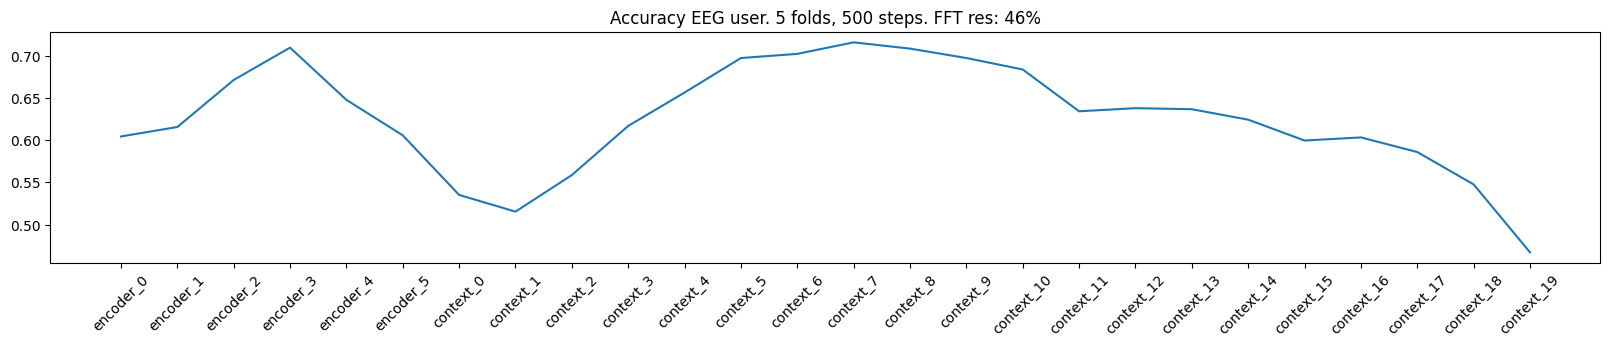

In [13]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 3)
plt.plot(names, res)
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.title("Accuracy EEG user. 5 folds, 500 steps. FFT res: 46%")
plt.show()


---encoder_0: 9.27%
---encoder_1: 18.17%
---encoder_2: 18.91%
---encoder_3: 25.10%
---encoder_4: 29.91%
---encoder_5: 30.41%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


---context_0: 68.36%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

---context_1: 65.89%
---context_2: 73.80%
---context_3: 79.73%
---context_4: 80.60%
---context_5: 83.43%
---context_6: 81.71%
---context_7: 83.19%
---context_8: 83.68%
---context_9: 82.32%
---context_10: 82.57%
---context_11: 80.60%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

---context_12: 80.96%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

---context_13: 80.10%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

---context_14: 78.12%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

---context_15: 78.61%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

---context_16: 77.50%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

---context_17: 77.75%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

---context_18: 73.05%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

---context_19: 67.49%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'Accuracy EEG user.Lin reg, 5 folds, do_norm=False')

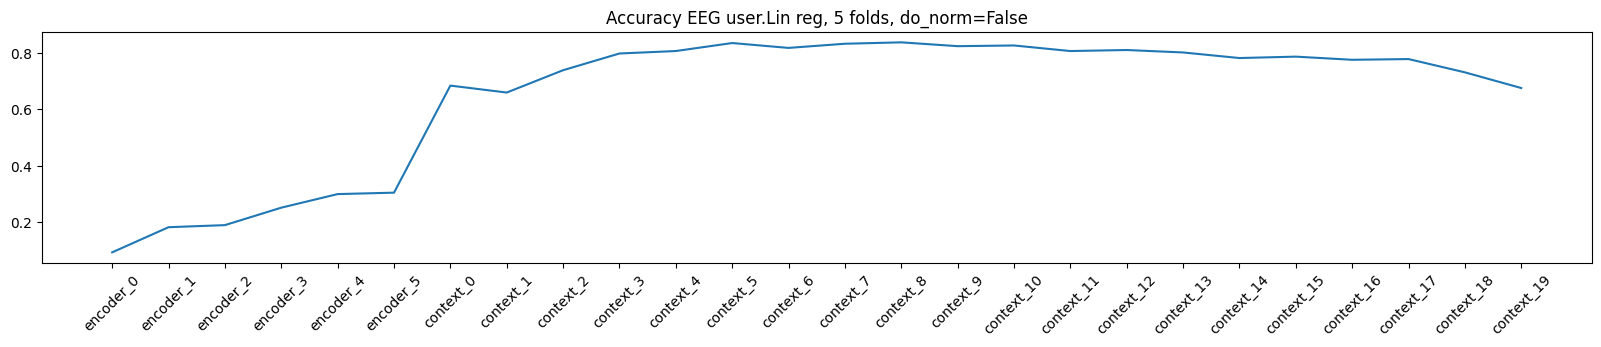

In [17]:
from eval.reg import evaluate_logistic_regression

res_lr = []
names_lr = []

for i in range(6):
    t = evaluate_logistic_regression(encoder_fs[i], uids, 'cv', do_norm=False)
    n = f'encoder_{i}'
    print(f"---{n}: {t * 100:.2f}%")
    res_lr.append(t)
    names_lr.append(n)
    
for i in range(20):
    t = evaluate_logistic_regression(trans_fs[i], uids, 'cv', do_norm=False)
    n = f'context_{i}'
    print(f"---{n}: {t * 100:.2f}%")
    res_lr.append(t)
    names_lr.append(n)
    
plt.plot(names_lr, res_lr)
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.title("Accuracy EEG user.Lin reg, 5 folds, do_norm=False")


---encoder_0: 6.43%
---encoder_1: 6.67%
---encoder_2: 8.54%
---encoder_3: 6.31%
---encoder_4: 8.41%
---encoder_5: 6.92%
---context_0: 8.28%
---context_1: 7.79%
---context_2: 9.65%
---context_3: 11.13%
---context_4: 11.74%
---context_5: 15.20%
---context_6: 14.71%
---context_7: 15.08%
---context_8: 16.56%
---context_9: 15.45%
---context_10: 12.60%
---context_11: 12.61%
---context_12: 10.02%
---context_13: 9.27%
---context_14: 10.13%
---context_15: 10.26%
---context_16: 9.39%
---context_17: 9.89%
---context_18: 9.02%
---context_19: 9.89%


Text(0.5, 1.0, 'Accuracy EEG user.Lin reg, 5 folds, do_norm=True')

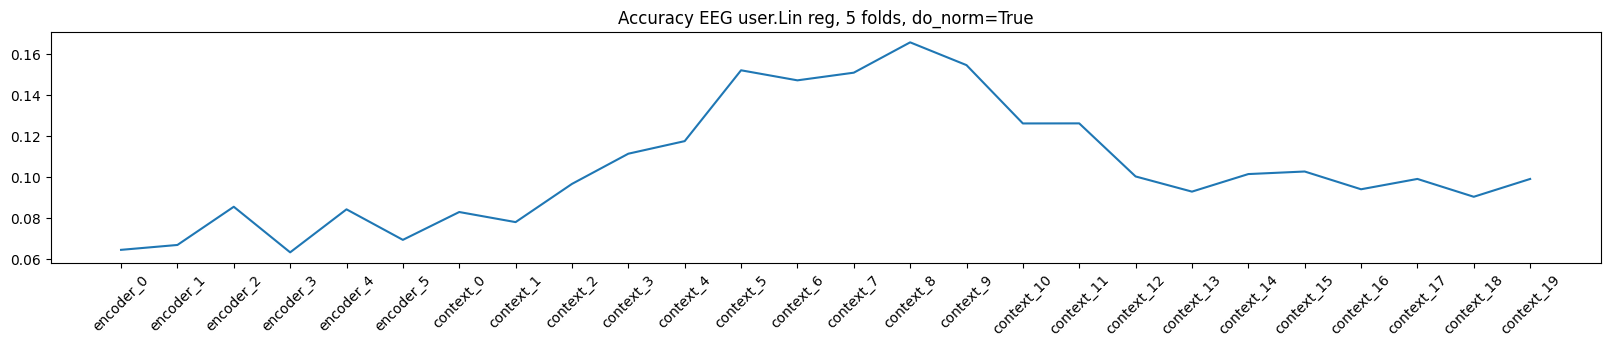

In [18]:
from eval.reg import evaluate_logistic_regression

res_lr = []
names_lr = []

for i in range(6):
    t = evaluate_logistic_regression(encoder_fs[i], uids, 'cv', do_norm=True)
    n = f'encoder_{i}'
    print(f"---{n}: {t * 100:.2f}%")
    res_lr.append(t)
    names_lr.append(n)
    
for i in range(20):
    t = evaluate_logistic_regression(trans_fs[i], uids, 'cv', do_norm=True)
    n = f'context_{i}'
    print(f"---{n}: {t * 100:.2f}%")
    res_lr.append(t)
    names_lr.append(n)
    
plt.plot(names_lr, res_lr)
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.title("Accuracy EEG user.Lin reg, 5 folds, do_norm=True")


In [16]:
evaluate_logistic_regression(fft_features, uids, 'cv', do_norm=False)

0.4375508013189172

In [8]:
from eval.reg import evaluate_catboost

evaluate_catboost(trans_fs[19], uids, do_norm=False)

Learning rate set to 0.105795
0:	learn: 4.1048024	total: 45.8ms	remaining: 22.9s
100:	learn: 1.2476377	total: 3.71s	remaining: 14.6s
200:	learn: 0.5263950	total: 7.18s	remaining: 10.7s
300:	learn: 0.2713925	total: 10.6s	remaining: 7.03s
400:	learn: 0.1674704	total: 14.2s	remaining: 3.5s
499:	learn: 0.1169258	total: 17.7s	remaining: 0us


0.5185185185185185

In [9]:
from eval.reg import evaluate_catboost

evaluate_catboost(trans_fs[19], uids, do_norm=True)

Learning rate set to 0.105795
0:	learn: 4.1054567	total: 49.2ms	remaining: 24.6s
100:	learn: 1.2365236	total: 4s	remaining: 15.8s
200:	learn: 0.5005355	total: 7.6s	remaining: 11.3s
300:	learn: 0.2540644	total: 11.1s	remaining: 7.37s
400:	learn: 0.1576376	total: 14.7s	remaining: 3.63s
499:	learn: 0.1100732	total: 18.1s	remaining: 0us


0.5

# 100 its

In [8]:
res = []
names = []

In [9]:
for i in range(6):
    t = evaluate_catboost_cv(encoder_fs[i], uids, num_steps=100)
    n = f'encoder_{i}'
    print(f"---{n}: {t * 100:.2f}%")
    res.append(t)
    names.append(n)

Learning rate set to 0.389518
0:	learn: 3.8173525	total: 49.7ms	remaining: 4.92s
99:	learn: 0.2341643	total: 3.58s	remaining: 0us
Fold 1 Accuracy: 0.5074
Learning rate set to 0.389518
0:	learn: 3.8441028	total: 39.4ms	remaining: 3.9s
99:	learn: 0.2351554	total: 3.55s	remaining: 0us
Fold 2 Accuracy: 0.5481
Learning rate set to 0.389666
0:	learn: 3.8156250	total: 38ms	remaining: 3.77s
99:	learn: 0.2201237	total: 3.54s	remaining: 0us
Fold 3 Accuracy: 0.5204
Mean Accuracy: 0.5253
---encoder_0: 52.53%
Learning rate set to 0.389518
0:	learn: 3.8904574	total: 34.7ms	remaining: 3.44s
99:	learn: 0.2230827	total: 3.55s	remaining: 0us
Fold 1 Accuracy: 0.5407
Learning rate set to 0.389518
0:	learn: 3.8657186	total: 37ms	remaining: 3.67s
99:	learn: 0.2234081	total: 3.52s	remaining: 0us
Fold 2 Accuracy: 0.5407
Learning rate set to 0.389666
0:	learn: 3.7853405	total: 34.8ms	remaining: 3.44s
99:	learn: 0.2274059	total: 3.48s	remaining: 0us
Fold 3 Accuracy: 0.5353
Mean Accuracy: 0.5389
---encoder_1: 53

In [17]:
len(trans_fs)

20

In [10]:
for i in range(20):
    t = evaluate_catboost_cv(trans_fs[i], uids, num_steps=100)
    n = f'context_{i}'
    print(f"---{n}: {t * 100:.2f}%")
    res.append(t)
    names.append(n)

Learning rate set to 0.389518
0:	learn: 3.9543317	total: 39.1ms	remaining: 3.87s
99:	learn: 0.2448286	total: 3.38s	remaining: 0us
Fold 1 Accuracy: 0.4333
Learning rate set to 0.389518
0:	learn: 3.9341808	total: 39.7ms	remaining: 3.93s
99:	learn: 0.2448232	total: 3.41s	remaining: 0us
Fold 2 Accuracy: 0.4741
Learning rate set to 0.389666
0:	learn: 3.9322202	total: 42.7ms	remaining: 4.23s
99:	learn: 0.2436302	total: 3.43s	remaining: 0us
Fold 3 Accuracy: 0.5242
Mean Accuracy: 0.4772
---context_0: 47.72%
Learning rate set to 0.389518
0:	learn: 3.9484274	total: 36.1ms	remaining: 3.57s
99:	learn: 0.2348968	total: 3.43s	remaining: 0us
Fold 1 Accuracy: 0.4259
Learning rate set to 0.389518
0:	learn: 3.9490489	total: 34.6ms	remaining: 3.42s
99:	learn: 0.2604165	total: 3.38s	remaining: 0us
Fold 2 Accuracy: 0.4111
Learning rate set to 0.389666
0:	learn: 3.9384395	total: 40.3ms	remaining: 3.99s
99:	learn: 0.2661340	total: 3.44s	remaining: 0us
Fold 3 Accuracy: 0.4610
Mean Accuracy: 0.4327
---context_

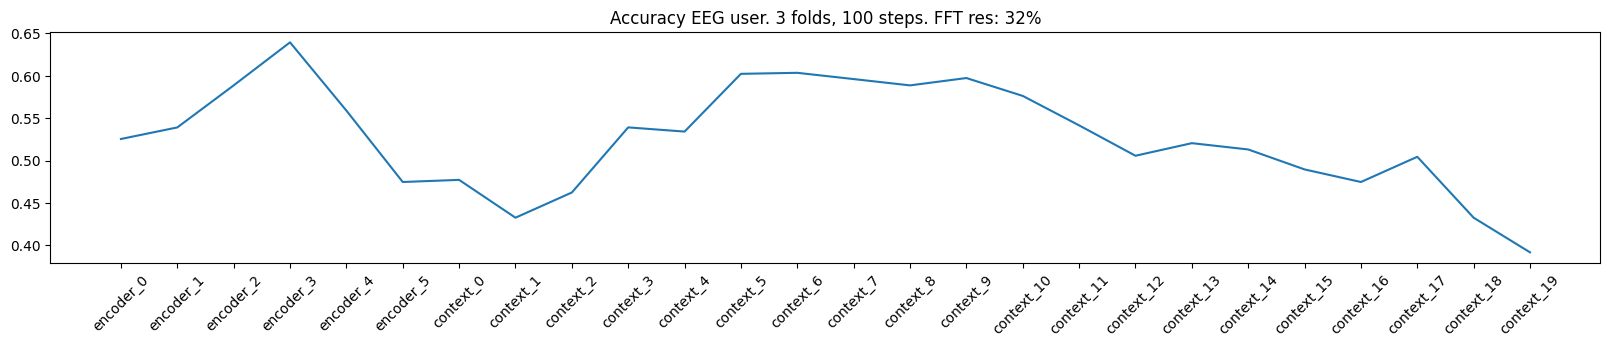

In [16]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 3)
plt.plot(names, res)
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.title("Accuracy EEG user. 3 folds, 100 steps. FFT res: 32%")
plt.show()


In [15]:
evaluate_catboost_cv(fft_features, uids, num_steps=100)

Learning rate set to 0.389518
0:	learn: 3.9466360	total: 283ms	remaining: 28s
99:	learn: 0.3364066	total: 22.7s	remaining: 0us
Fold 1 Accuracy: 0.3074
Learning rate set to 0.389518
0:	learn: 4.0073650	total: 219ms	remaining: 21.7s
99:	learn: 0.3185762	total: 22.7s	remaining: 0us
Fold 2 Accuracy: 0.2963
Learning rate set to 0.389666
0:	learn: 4.0150526	total: 240ms	remaining: 23.8s
99:	learn: 0.3293293	total: 22.6s	remaining: 0us
Fold 3 Accuracy: 0.3792
Mean Accuracy: 0.3276


0.3276286199458442

In [61]:
a, b = torch.unique(uids, return_counts=True)
a[48], b[48]

(tensor(49), tensor(1))

In [53]:
evaluate_catboost(fft_features, uids, do_norm=False)

Learning rate set to 0.059408
0:	learn: 4.1366577	total: 272ms	remaining: 4m 31s
100:	learn: 1.9944168	total: 25.8s	remaining: 3m 49s
200:	learn: 1.2009626	total: 49.7s	remaining: 3m 17s
300:	learn: 0.7637089	total: 1m 13s	remaining: 2m 49s
400:	learn: 0.5231189	total: 1m 36s	remaining: 2m 23s
500:	learn: 0.3828653	total: 1m 59s	remaining: 1m 58s
600:	learn: 0.2891234	total: 2m 22s	remaining: 1m 34s
700:	learn: 0.2264297	total: 2m 45s	remaining: 1m 10s
800:	learn: 0.1806322	total: 3m 8s	remaining: 46.8s
900:	learn: 0.1504147	total: 3m 31s	remaining: 23.2s
999:	learn: 0.1258671	total: 3m 54s	remaining: 0us


0.4691358024691358

In [43]:
evaluate_catboost(encoder_fs[0], uids, do_norm=False)

Learning rate set to 0.059408
0:	learn: 4.1130955	total: 44.4ms	remaining: 44.3s
100:	learn: 1.7234284	total: 3.78s	remaining: 33.6s
200:	learn: 0.9945490	total: 7.45s	remaining: 29.6s
300:	learn: 0.6711928	total: 11s	remaining: 25.6s
400:	learn: 0.4703951	total: 14.6s	remaining: 21.8s
500:	learn: 0.3417158	total: 18.2s	remaining: 18.1s
600:	learn: 0.2610137	total: 21.8s	remaining: 14.5s
700:	learn: 0.2091005	total: 25.4s	remaining: 10.8s
800:	learn: 0.1689859	total: 29s	remaining: 7.2s
900:	learn: 0.1410046	total: 32.6s	remaining: 3.58s
999:	learn: 0.1202106	total: 36.1s	remaining: 0us


0.5555555555555556

In [44]:
evaluate_catboost(encoder_fs[3], uids, do_norm=False)

Learning rate set to 0.059408
0:	learn: 4.1200765	total: 37.7ms	remaining: 37.6s
100:	learn: 1.4506545	total: 3.81s	remaining: 34s
200:	learn: 0.7663074	total: 7.4s	remaining: 29.4s
300:	learn: 0.4854876	total: 10.9s	remaining: 25.3s
400:	learn: 0.3444691	total: 14.4s	remaining: 21.5s
500:	learn: 0.2509219	total: 17.9s	remaining: 17.9s
600:	learn: 0.1881592	total: 21.5s	remaining: 14.3s
700:	learn: 0.1472240	total: 25s	remaining: 10.7s
800:	learn: 0.1211545	total: 28.6s	remaining: 7.1s
900:	learn: 0.1012269	total: 32.1s	remaining: 3.53s
999:	learn: 0.0864869	total: 35.7s	remaining: 0us


0.7098765432098766

In [45]:
evaluate_catboost(encoder_fs[5], uids, do_norm=False)

Learning rate set to 0.059408
0:	learn: 4.1322074	total: 40.3ms	remaining: 40.3s
100:	learn: 1.6698134	total: 3.88s	remaining: 34.6s
200:	learn: 0.9535362	total: 7.47s	remaining: 29.7s
300:	learn: 0.6161400	total: 11s	remaining: 25.5s
400:	learn: 0.4236489	total: 14.5s	remaining: 21.7s
500:	learn: 0.3060539	total: 18s	remaining: 17.9s
600:	learn: 0.2316673	total: 21.5s	remaining: 14.3s
700:	learn: 0.1822538	total: 25s	remaining: 10.7s
800:	learn: 0.1487425	total: 28.5s	remaining: 7.09s
900:	learn: 0.1236747	total: 32.2s	remaining: 3.53s
999:	learn: 0.1044733	total: 35.8s	remaining: 0us


0.5740740740740741

In [34]:
evaluate_catboost(trans_fs[5], uids, do_norm=False)

Learning rate set to 0.059408
0:	learn: 4.1266374	total: 39.7ms	remaining: 39.7s
100:	learn: 1.6123533	total: 3.75s	remaining: 33.3s
200:	learn: 0.8217438	total: 7.33s	remaining: 29.1s
300:	learn: 0.5004284	total: 10.9s	remaining: 25.3s
400:	learn: 0.3380553	total: 14.4s	remaining: 21.5s
500:	learn: 0.2381825	total: 17.9s	remaining: 17.8s
600:	learn: 0.1813905	total: 21.3s	remaining: 14.2s
700:	learn: 0.1434527	total: 24.8s	remaining: 10.6s
800:	learn: 0.1164212	total: 28.2s	remaining: 7.02s
900:	learn: 0.0969009	total: 31.7s	remaining: 3.48s
999:	learn: 0.0831354	total: 35.2s	remaining: 0us


0.7530864197530864

In [35]:
evaluate_catboost(trans_fs[10], uids, do_norm=False)

Learning rate set to 0.059408
0:	learn: 4.1321068	total: 36.9ms	remaining: 36.8s
100:	learn: 1.6409942	total: 3.83s	remaining: 34s
200:	learn: 0.8665868	total: 7.42s	remaining: 29.5s
300:	learn: 0.5233054	total: 10.9s	remaining: 25.3s
400:	learn: 0.3478966	total: 14.3s	remaining: 21.4s
500:	learn: 0.2495405	total: 17.8s	remaining: 17.7s
600:	learn: 0.1892969	total: 21.3s	remaining: 14.1s
700:	learn: 0.1481863	total: 24.7s	remaining: 10.6s
800:	learn: 0.1224821	total: 28.2s	remaining: 7s
900:	learn: 0.1014412	total: 31.7s	remaining: 3.49s
999:	learn: 0.0869716	total: 35.3s	remaining: 0us


0.6728395061728395

In [36]:
evaluate_catboost(trans_fs[15], uids, do_norm=False)

Learning rate set to 0.059408
0:	learn: 4.1297057	total: 41ms	remaining: 41s
100:	learn: 1.8006204	total: 3.83s	remaining: 34.1s
200:	learn: 0.9623844	total: 7.43s	remaining: 29.5s
300:	learn: 0.5818727	total: 11s	remaining: 25.4s
400:	learn: 0.4015065	total: 14.4s	remaining: 21.5s
500:	learn: 0.2834279	total: 17.9s	remaining: 17.8s
600:	learn: 0.2140688	total: 21.4s	remaining: 14.2s
700:	learn: 0.1691048	total: 24.9s	remaining: 10.6s
800:	learn: 0.1388342	total: 28.4s	remaining: 7.04s
900:	learn: 0.1146089	total: 31.8s	remaining: 3.5s
999:	learn: 0.0973808	total: 35.3s	remaining: 0us


0.6358024691358025

In [37]:
evaluate_catboost(trans_fs[19], uids, do_norm=False)

Learning rate set to 0.059408
0:	learn: 4.1453579	total: 43.2ms	remaining: 43.2s
100:	learn: 2.0049065	total: 3.87s	remaining: 34.5s
200:	learn: 1.0883414	total: 7.58s	remaining: 30.1s
300:	learn: 0.6455502	total: 11.2s	remaining: 26s
400:	learn: 0.4332228	total: 14.7s	remaining: 21.9s
500:	learn: 0.2992699	total: 18.3s	remaining: 18.2s
600:	learn: 0.2229491	total: 21.8s	remaining: 14.5s
700:	learn: 0.1719613	total: 25.3s	remaining: 10.8s
800:	learn: 0.1382021	total: 28.9s	remaining: 7.19s
900:	learn: 0.1145064	total: 32.5s	remaining: 3.57s
999:	learn: 0.0966409	total: 36s	remaining: 0us


0.5123456790123457

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import torch
import time
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def evaluate_catboost(X: torch.Tensor, y: torch.Tensor, do_norm):
    if do_norm:
        X = X / torch.norm(X, dim=1, keepdim=True)
    X_np = X.numpy()
    y_np = y.numpy()

    X_train, X_val, y_train, y_val = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

    train_pool = Pool(data=X_train, label=y_train)
    val_pool = Pool(data=X_val, label=y_val)

    model = CatBoostClassifier(task_type='GPU', iterations=1000, verbose=100)

    model.fit(train_pool, early_stopping_rounds=50)

    y_val_pred = model.predict(val_pool)
    acc = accuracy_score(y_val, y_val_pred)
    return acc

In [23]:
evaluate_catboost(vecs, uids, do_norm=True)

Learning rate set to 0.059408
0:	learn: 4.1273355	total: 39.5ms	remaining: 39.5s
100:	learn: 1.9935668	total: 3.91s	remaining: 34.8s
200:	learn: 1.0711482	total: 7.6s	remaining: 30.2s
300:	learn: 0.6440745	total: 11.2s	remaining: 26s
400:	learn: 0.4120770	total: 14.8s	remaining: 22.1s
500:	learn: 0.2861988	total: 18.4s	remaining: 18.3s
600:	learn: 0.2097623	total: 21.9s	remaining: 14.6s
700:	learn: 0.1630517	total: 25.5s	remaining: 10.9s
800:	learn: 0.1313118	total: 29.1s	remaining: 7.22s
900:	learn: 0.1084704	total: 32.6s	remaining: 3.59s
999:	learn: 0.0926046	total: 36.2s	remaining: 0us


0.5308641975308642

In [24]:
evaluate_catboost(vecs, uids, do_norm=False)

Learning rate set to 0.059408
0:	learn: 4.1246474	total: 37.9ms	remaining: 37.8s


100:	learn: 2.0158409	total: 3.78s	remaining: 33.7s
200:	learn: 1.0926598	total: 7.4s	remaining: 29.4s
300:	learn: 0.6662593	total: 10.9s	remaining: 25.4s
400:	learn: 0.4426410	total: 14.4s	remaining: 21.5s
500:	learn: 0.3113039	total: 17.9s	remaining: 17.8s
600:	learn: 0.2289076	total: 21.4s	remaining: 14.2s
700:	learn: 0.1765414	total: 24.9s	remaining: 10.6s
800:	learn: 0.1414910	total: 28.4s	remaining: 7.06s
900:	learn: 0.1165671	total: 31.9s	remaining: 3.5s
999:	learn: 0.0994802	total: 35.3s	remaining: 0us


0.5308641975308642

In [25]:
evaluate_catboost(med, uids, do_norm=False)

Learning rate set to 0.059408
0:	learn: 4.1025383	total: 42.2ms	remaining: 42.2s
100:	learn: 1.7217166	total: 3.83s	remaining: 34.1s
200:	learn: 0.9948503	total: 7.39s	remaining: 29.4s
300:	learn: 0.6540145	total: 10.8s	remaining: 25.1s
400:	learn: 0.4462576	total: 14.2s	remaining: 21.3s
500:	learn: 0.3210347	total: 17.7s	remaining: 17.6s
600:	learn: 0.2444632	total: 21.1s	remaining: 14s
700:	learn: 0.1915031	total: 24.5s	remaining: 10.5s
800:	learn: 0.1537082	total: 28s	remaining: 6.95s
900:	learn: 0.1267302	total: 31.5s	remaining: 3.46s
999:	learn: 0.1074604	total: 34.9s	remaining: 0us


0.6358024691358025

In [26]:
evaluate_catboost(med, uids, do_norm=True)

Learning rate set to 0.059408
0:	learn: 4.1154985	total: 38.8ms	remaining: 38.8s
100:	learn: 1.8816662	total: 3.77s	remaining: 33.6s
200:	learn: 1.1348455	total: 7.34s	remaining: 29.2s
300:	learn: 0.7561125	total: 10.8s	remaining: 25.2s
400:	learn: 0.5156052	total: 14.3s	remaining: 21.4s
500:	learn: 0.3635849	total: 17.8s	remaining: 17.7s
600:	learn: 0.2744522	total: 21.3s	remaining: 14.1s
700:	learn: 0.2133567	total: 24.7s	remaining: 10.6s
800:	learn: 0.1703199	total: 28.2s	remaining: 7.01s
900:	learn: 0.1400361	total: 31.7s	remaining: 3.48s
999:	learn: 0.1184204	total: 35.1s	remaining: 0us


0.5555555555555556